In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.284237 -0.267978 -0.317115 -0.661420 -0.408390 -0.232062  0.057006   
  1   1.102009 -0.423401 -0.627328 -0.458179  0.087508 -0.650422 -0.414215   
  2   0.561643 -0.794790  0.004090 -0.495689  0.288304 -0.335888 -0.094211   
  3  -0.190770 -0.726574 -0.885826 -0.028709 -0.191403  0.514526 -0.295534   
  4   0.183888 -0.179806 -0.730738 -0.873608 -0.270576 -1.034182 -1.586457   
  5   1.221253 -0.267097 -0.543926 -0.886649 -0.911483 -0.476343 -0.016793   
  6   0.320997 -0.434767 -0.347435 -0.346376  0.223392  0.037611 -1.428183   
  7   0.159490 -0.784026 -0.492956 -0.142972  0.489798 -0.290107 -0.270179   
  8   1.074550  0.057604 -0.163284 -0.593006 -2.017851 -1.097431 -0.846525   
  9   0.035126 -1.699453 -0.599979 -0.715183 -0.123369  0.356507 -0.304739   
  10  0.527920 -1.109883 -0.980422 -1.667034 -0.352528 -0.242858 -1.236390   
  11  1.209366 -0.776309 -1.349015  0.078725 -0.086569  0.002402  0.529239   
  12 -0.381608 -0.513072 -0.580766 -1.327642 -0.242040  0.434121 -0.135446   
  13  1.133095 -0.806128 -0.143437 -0.144576 -0.892644  0.235095 -0.132708   
  14  1.416490  0.108111  0.431256 -0.813814 -0.316774 -0.236899 -1.066029   
  15  0.183097 -0.953111 -1.822969 -1.471381 -1.127974 -0.367302  0.069444   
  16  0.319990 -0.514280 -0.694972 -0.650360 -0.948456 -0.266120 -0.245672   
  17  0.756361  0.247418  0.055000 -0.749343 -0.278804  0.418414 -0.667560   
  18  0.061225 -1.291667 -1.518404 -0.702641 -1.003213 -0.016594 -0.621914   
  19  0.261573  0.145964 -0.542591  0.850080  0.491419 -0.574794 -0.575974   
  20  0.912201  0.087831 -0.196051 -0.676160 -0.558996 -0.550927  0.277187   
  21 -0.325780  0.561068  0.054430 -0.800101  0.151010 -0.277525  0.876835   
  22 -0.809905 -0.192301 -0.401976 -0.282764 -0.772638  0.241924  0.119279   
  23  0.780960 -0.246248  0.114977 -0.076091  0.422237 -1.188125 -0.276509   
  24  0.463729  0.087772 -0.056482 -1.116098 -0.223741  0.522747  0.300355   
1 0  -0.943269 -0.800041 -0.302193 -1.157775  0.060943 -1.080407 -0.308845   
  1   0.156095 -0.374384  0.342919 -0.075540  0.468993  0.147947 -0.900660   
  2  -0.807785 -1.666803 -0.585176 -0.232807  0.006210 -0.628996 -0.239215   
  3   0.856860 -0.876960 -1.192663 -0.091496  0.876753  0.201247 -0.315710   
  4   1.207283 -0.989715  0.470792 -0.113827  0.188202 -0.492487  0.886809   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.331692  0.046357  0.968766  ... -0.391610  0.277829  0.264187   
  1   1.616774 -0.171628 -0.332810  ... -0.253456  1.461853  0.890664   
  2   0.691321 -1.769042  0.889502  ...  0.526655  0.424170  0.906126   
  3  -0.016092  0.331293  0.310067  ...  1.152665  0.439487  0.231333   
  4  -0.439073  0.501269  0.372292  ...  0.823166  0.348035  0.642426   
  5  -0.115201 -0.307536 -0.218982  ...  0.419615  0.546088  0.924399   
  6  -0.479786  0.489950 -0.790269  ...  0.508369  0.764035  0.093308   
  7  -0.424393 -0.305370  0.657446  ...  0.529996 -0.699419  0.483357   
  8  -0.879625  0.129183  0.161327  ...  0.032023  0.865359 -0.294680   
  9  -0.123347  0.776627  1.419709  ... -0.589345 -0.213384 -0.241527   
  10  0.288548 -1.104099 -1.038789  ...  0.721974  1.526357 -0.034524   
  11 -0.375567 -0.496961  1.157537  ... -0.063427  0.407948 -0.074646   
  12 -0.819423 -0.508044 -0.238540  ... -0.689173  0.279517 -0.116455   
  13 -0.017028  0.584669  0.061111  ...  0.316874  0.347676  0.190811   
  14 -1.302423 -0.631837 -0.706152  ...  0.343536  1.249233 -0.291048   
  15  0.262523 -0.444184  0.277983  ... -0.747815 -0.016963  0.550660   
  16  0.847367  0.295592  0.496955  ...  0.122202  0.520667 -0.044324   
  17  0.343178 -0.630119 -0.577915  ... -0.081084  0.496227  0.362703   
  18  0.796617 -0.139155  0.372436  ... -0.661475  0.704883 -0.411526   
  19 -0.122433 -0.236965  0.201318  ... -0.231139  0.910228  1.641744   
  20  0.773193 -0.223883  0.638492  ...  0.153312  1.318544 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.119631  0.038341  29.202024  1.827805e-187  1.044485  1.194778


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



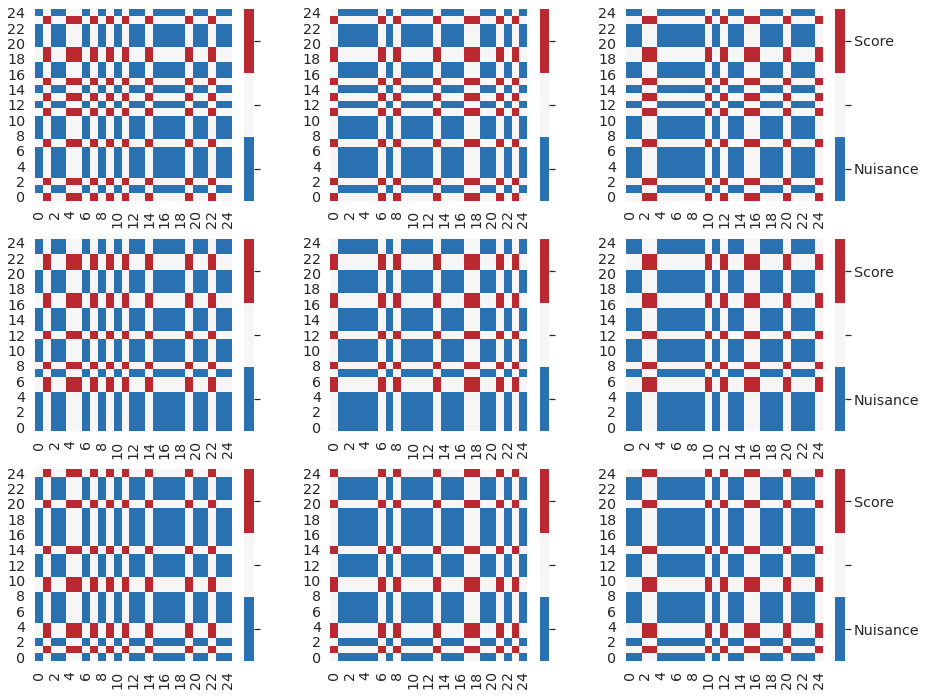

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



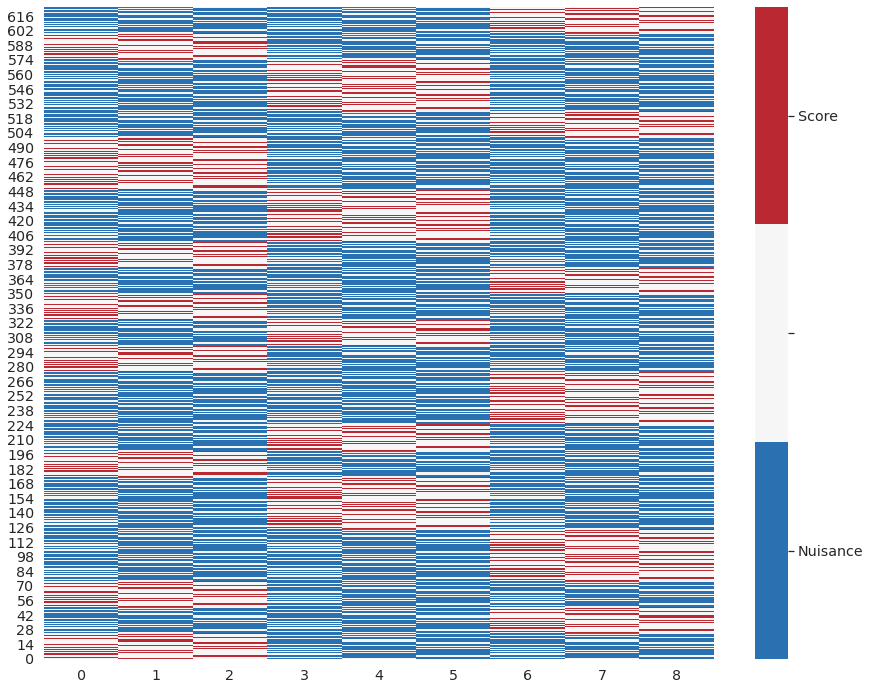

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])